# Figures
This Jupyter notebook shows how all the figures were generated in the paper *Discovery of Physics from Data: Universal Laws and Discrepancy Models.*

In [1]:
import warnings

from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import NullFormatter
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import seaborn as sns
from sklearn import preprocessing

# My helper code
import helpers

Import the data set and create a DataFrame containing ball properties.

In [2]:
data_file = "../data/Ball_drops_data.xls"
bd_data = pd.read_excel(data_file, sheet_name=None)

# Remove bowling ball
del bd_data["Bowling Ball"]
ball_list = list(bd_data.keys())
print("\n".join(ball_list))


# Weight was measured in oz
weight = {
    "Baseball": 5,
    "Blue Basketball": 18,
    "Green Basketball": 16,
    "Volleyball": np.NaN,
    "Golf Ball": 1.6,
    "Tennis Ball": 2,
    "Whiffle Ball 1": 1,
    "Whiffle Ball 2": 1,
    "Yellow Whiffle Ball": 1.5,
    "Orange Whiffle Ball": 1.5,
}

# Circumference was measured in cm
circumference = {
    "Baseball": 22.25,
    "Blue Basketball": 75.0,
    "Green Basketball": 73.25,
    "Volleyball": np.NaN,
    "Golf Ball": 13.8,
    "Tennis Ball": 20.75,
    "Whiffle Ball 1": 22.8,
    "Whiffle Ball 2": 22.8,
    "Yellow Whiffle Ball": 29.0,
    "Orange Whiffle Ball": 29.0,
}

# Convert weight to mass (kg)
mass = {key: 0.0283495 * value for key, value in weight.items()}

# Convert circumference to radius (m)
radius = {key: value / (100 * 2 * np.pi) for key, value in circumference.items()}


Baseball
Blue Basketball
Green Basketball
Volleyball
Golf Ball
Tennis Ball
Whiffle Ball 1
Whiffle Ball 2
Yellow Whiffle Ball
Orange Whiffle Ball


## Parameters

In [3]:
# Smoother to use when performing numerical differentiation
smoother = "savgol"

# Length of window to pass into smoother for numerical differentiation
window_length = 35

# Whether or not to save the generated plots
save_plots = False

# Start and end all balls at same heights (in plots, not when applying SINDy)
start_height = 40
end_height = 5

Determine the minimum number of time steps across all balls and drops

## Figure 3: Ball drop visualization

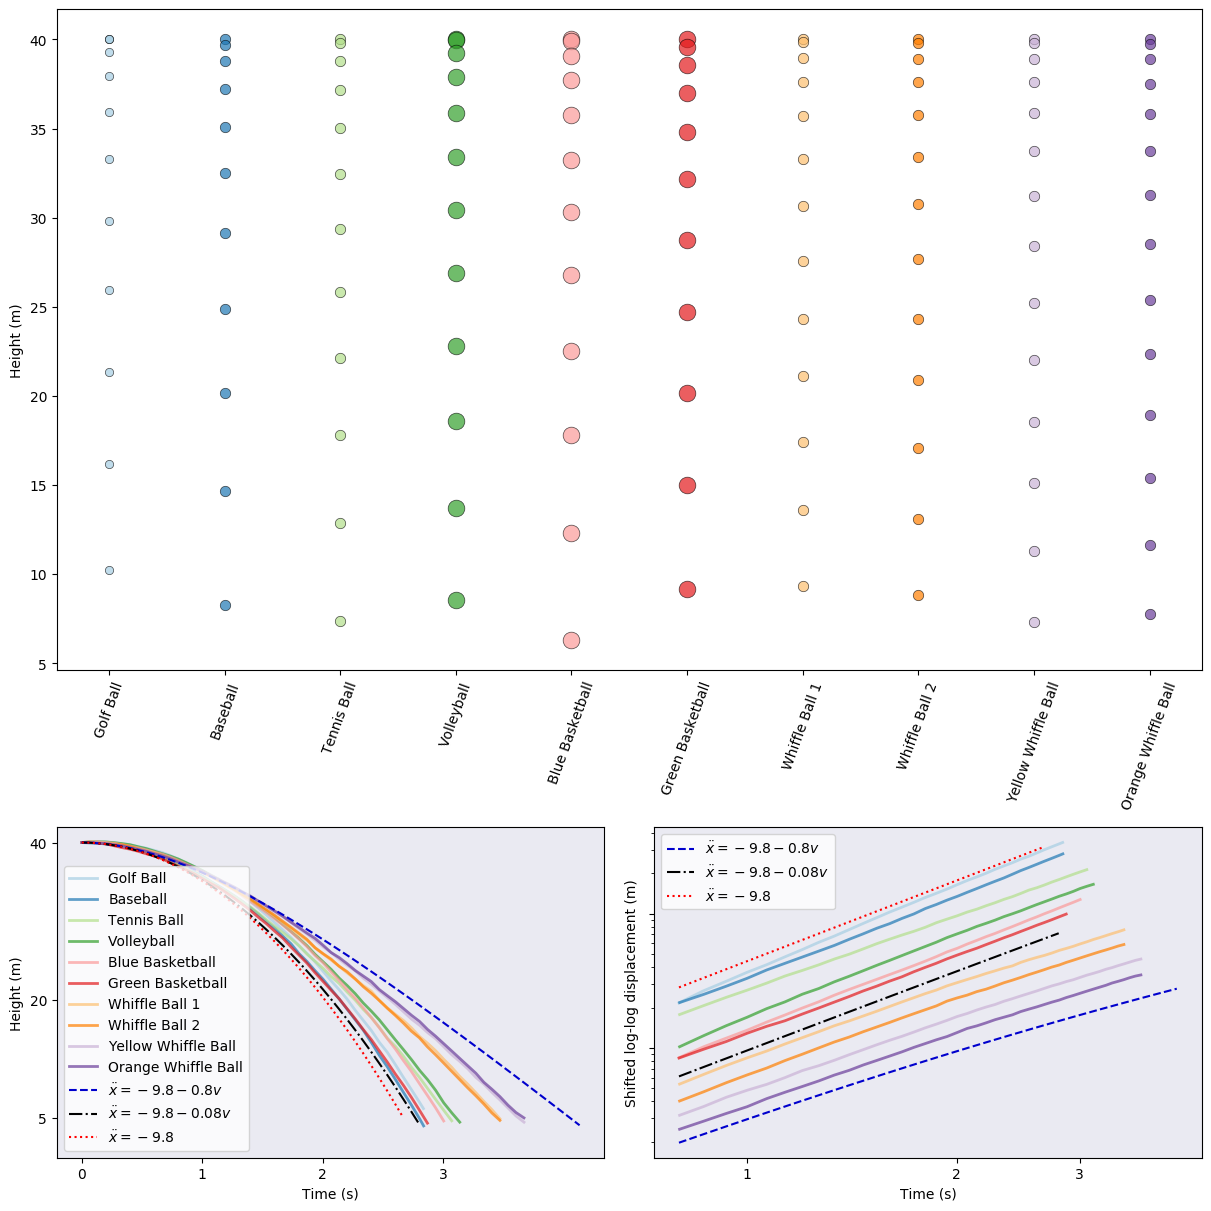

In [4]:
# ----------------------------------------------------------
# Preliminaries
# ----------------------------------------------------------

# Ball ordering to use in visualization
drop_viz_list = [
    "Golf Ball",
    "Baseball",
    "Tennis Ball",
    "Volleyball",
    "Blue Basketball",
    "Green Basketball",
    "Whiffle Ball 1",
    "Whiffle Ball 2",
    "Yellow Whiffle Ball",
    "Orange Whiffle Ball",
]
n_balls = len(ball_list)

# Which drop to use (1 or 2)
drop = 2

# How much to downsample the balls' trajectories
sample_period = 4

# Plot options
sns.reset_defaults()
pal = sns.color_palette("Paired", n_colors=10)
viz_colors = dict(zip(drop_viz_list, pal))
viz_radius = {
    "Baseball": 2.5,
    "Blue Basketball": 4,
    "Green Basketball": 4,
    "Volleyball": 4,
    "Golf Ball": 2,
    "Tennis Ball": 2.5,
    "Whiffle Ball 1": 2.5,
    "Whiffle Ball 2": 2.5,
    "Yellow Whiffle Ball": 2.5,
    "Orange Whiffle Ball": 2.5,
}

# Put all three plots in same figure
fig = plt.figure(constrained_layout=True, figsize=(12, 12))
gs = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)


# ----------------------------------------------------------
# Strobe light version
# ----------------------------------------------------------
ax = fig.add_subplot(gs[0:2, :])

for k, ball in enumerate(drop_viz_list):
    ball_df = bd_data[ball].loc[bd_data[ball]["Drop #"] == drop]
    h = ball_df["Height (m)"].values

    # Shift so that all balls start at same height
    h += start_height - h[0]

    # Shift so that no points past end height
    h = h[h > end_height]

    # Subsample
    inds = np.arange(len(h))
    h_sub = h[inds % sample_period == 0]

    # Plot
    x = k * np.ones(len(h_sub))
    ax.plot(
        x,
        h_sub,
        "o",
        color=viz_colors[ball],
        markersize=3 * viz_radius[ball],
        markeredgecolor="black",
        markeredgewidth=0.5,
        alpha=0.7,
    )

# Tweak axes
ax.set(xticks=np.arange(n_balls), xticklabels=drop_viz_list, ylabel="Height (m)")
ax.tick_params(axis="x", labelrotation=70)


# ----------------------------------------------------------
# Trajectory versions
# ----------------------------------------------------------

ax1 = fig.add_subplot(gs[2, 0])
ax2 = fig.add_subplot(gs[2, 1])

kwargs = {
    "alpha": 0.7,
    "linewidth": 2,
}

# Amount by which to shift each ball trajectory
# so that all are simultaneously visible
vertical_shift = np.logspace(1, 0, num=n_balls)

for k, ball in enumerate(drop_viz_list):
    ball_df = bd_data[ball].loc[bd_data[ball]["Drop #"] == drop]
    h = ball_df["Height (m)"].values
    t = ball_df["Time (s)"].values

    h += start_height - h[0]
    displacement = np.max(h) - h

    # Omit early part of trajectories
    later_times = t >= 0.75

    # Plot
    x = k * np.ones(len(h_sub))
    ax1.plot(t, h, color=viz_colors[ball], label=ball, **kwargs)
    ax2.plot(
        t[later_times],
        vertical_shift[k] * displacement[later_times],
        color=viz_colors[ball],
        **kwargs
    )


# Add constant acceleration and (constant acceleration + drag) trajectories
h_term_slow, t_term_slow = helpers.synthetic_ball_drop(
    -9.8, -0.8, h0=40, timesteps=100
)
h_term_fast, t_term_fast = helpers.synthetic_ball_drop(
    -9.8, -0.08, h0=40, timesteps=100
)
h_const_accel, t_const_accel = helpers.synthetic_ball_drop(
    -9.8, 0, h0=40, timesteps=100
)

h_inds_tslow = h_term_slow > 4
h_inds_tfast = h_term_fast > 4
h_inds_ca = h_const_accel > 4

ax1.plot(
    t_term_slow[h_inds_tslow],
    h_term_slow[h_inds_tslow],
    "--",
    label=r"$\ddot x=-9.8 - 0.8v$",
    color="mediumblue",
)
ax1.plot(
    t_term_fast[h_inds_tfast],
    h_term_fast[h_inds_tfast],
    "-.",
    label=r"$\ddot x=-9.8 - 0.08v$",
    color="black",
)
ax1.plot(
    t_const_accel[h_inds_ca],
    h_const_accel[h_inds_ca],
    ":",
    label=r"$\ddot x=-9.8$",
    color="red",
)


# Add constant acceleration and (constant acceleration + drag) to log-log displacement plot
t_inds_tslow = t_term_slow > 0.75
t_inds_tfast = t_term_fast > 0.75
t_inds_ca = t_const_accel > 0.75

trimmed_inds_tslow = h_inds_tslow * t_inds_tslow
trimmed_inds_tfast = h_inds_tfast * t_inds_tfast
trimmed_inds_ca = h_inds_ca * t_inds_ca

h_disp_tslow = h_term_slow[0] - h_term_slow
h_disp_tfast = h_term_fast[0] - h_term_fast
h_disp_ca = h_const_accel[0] - h_const_accel

ax2.plot(
    t_term_slow[trimmed_inds_tslow],
    h_disp_tslow[trimmed_inds_tslow] / 1.3,
    "--",
    label=r"$\ddot x=-9.8 - 0.8v$",
    color="mediumblue",
)
ax2.plot(
    t_term_fast[trimmed_inds_tfast],
    2 * h_disp_tfast[trimmed_inds_tfast],
    "-.",
    label=r"$\ddot x=-9.8 - 0.08v$",
    color="black",
)
ax2.plot(
    t_const_accel[trimmed_inds_ca],
    9 * h_disp_ca[trimmed_inds_ca],
    ":",
    label=r"$\ddot x=-9.8$",
    color="red",
)

# Specify axis options
ax1.set(ylabel="Height (m)", yticks=[40, 20, 5], xlabel="Time (s)")
ax1.set_xticks([0, 1, 2, 3])
ax1.set_ylim(bottom=0)
ax1.legend(loc="lower left")
ax2.set(
    ylabel="Shifted log-log displacement (m)",
    xlabel="Time (s)",
    xscale="log",
    yscale="log",
)
ax2.set_xticks([1, 2, 3])
ax2.xaxis.set_minor_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.xaxis.set_tick_params(which="minor", size=0)
ax2.xaxis.set_tick_params(which="minor", width=0)
ax2.legend()

# We need to resort to a special trick to remove ticks on log plot.
# See https://github.com/matplotlib/matplotlib/issues/8027
ax2.yaxis.set_major_formatter(NullFormatter())
ax2.yaxis.set_minor_formatter(NullFormatter())

# Set axis backgrounds to light gray
ax1.set_facecolor("#EAEAF2")
ax2.set_facecolor("#EAEAF2")


# Save results
if save_plots:
    fname = "figures/ball_drops"
    plt.savefig(fname + ".pdf", bbox_inches="tight", pad_inches=0)

plt.show()

## Figure 4: Landing time vs. other factors

Get the minimum number of timesteps across all drops

In [5]:
end_time_idx = 100

for drop in [1, 2]:
    for ball in viz_colors.keys():
        ball_df = bd_data[ball].loc[bd_data[ball]["Drop #"] == drop]
        h = ball_df["Height (m)"].values
        t = ball_df["Time (s)"].values

        ntc = helpers.need_to_clip(t)
        if ntc:
            h = h[:ntc]
            t = t[:ntc]

        if len(t) < end_time_idx:
            end_time_idx = len(t)
            print("Shortened to", len(t), "for", ball)

Shortened to 42 for Golf Ball


Get the max (standardized) stopping height across all balls

In [6]:
max_stop_height = 0

for drop in [1, 2]:
    for ball in viz_colors.keys():
        ball_df = bd_data[ball].loc[bd_data[ball]["Drop #"] == drop]
        h = ball_df["Height (m)"].values

        h = h[:end_time_idx]

        # Standardize height
        h += start_height - h[0]

        if h[-1] > max_stop_height:
            max_stop_height = h[-1]


Get landing times for each ball

In [7]:
land_times = {}
for drop in [1, 2]:
    land_times[drop] = {}
    for ball in viz_colors.keys():
        ball_df = bd_data[ball].loc[bd_data[ball]["Drop #"] == drop]
        h = ball_df["Height (m)"].values
        t = ball_df["Time (s)"].values

        # Standardize height
        h += start_height - h[0]

        # Get landing time
        land_idx = np.argmax(h <= max_stop_height)
        land_times[drop][ball] = t[land_idx]


# Store other ball properties in same dataframe
df1 = pd.DataFrame.from_dict(land_times[1], orient="index", columns=["Land time"])
df1["Mass (kg)"] = pd.DataFrame.from_dict(mass, orient="index")
df1["Radius (m)"] = pd.DataFrame.from_dict(radius, orient="index")
df1["Density"] = df1["Mass (kg)"] / ((4 * np.pi / 3) * df1["Radius (m)"] ** 3)
df1["Surface area"] = 4 * np.pi * df1["Radius (m)"] ** 2
df1["Surface area / mass"] = 4 * np.pi * df1["Radius (m)"] ** 2 / df1["Mass (kg)"]
df1["Mass / surface area"] = df1["Mass (kg)"] / (4 * np.pi * df1["Radius (m)"] ** 2)


df2 = pd.DataFrame.from_dict(land_times[1], orient="index", columns=["Land time"])
df2["Mass (kg)"] = pd.DataFrame.from_dict(mass, orient="index")
df2["Radius (m)"] = pd.DataFrame.from_dict(radius, orient="index")
df2["Density"] = df2["Mass (kg)"] / ((4 * np.pi / 3) * df2["Radius (m)"] ** 3)
df2["Surface area"] = 4 * np.pi * df2["Radius (m)"] ** 2
df2["Surface area / mass"] = 4 * np.pi * df2["Radius (m)"] ** 2 / df2["Mass (kg)"]
df2["Mass / surface area"] = df2["Mass (kg)"] / (4 * np.pi * df2["Radius (m)"] ** 2)


Generate plots

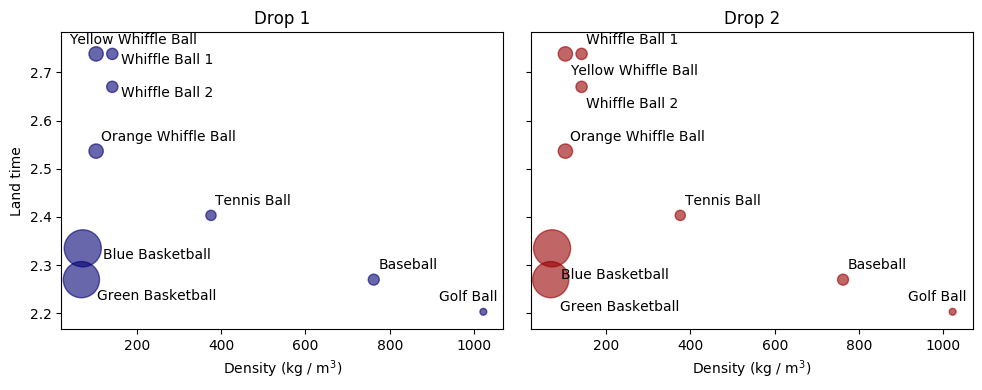

In [8]:
# Pick colors
c = ["deep blue", "blood red"]
colors = sns.xkcd_palette(c)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Features to plot
feature_x = "Density"
feature_y = "Land time"

df1.plot(
    x=feature_x,
    y=feature_y,
    s=50000 * df1["Radius (m)"] ** 2,
    kind="scatter",
    alpha=0.6,
    ax=axs[0],
    c=np.array([colors[0]]),
)
df2.plot(
    x=feature_x,
    y=feature_y,
    s=50000 * df2["Radius (m)"] ** 2,
    kind="scatter",
    alpha=0.6,
    ax=axs[1],
    c=np.array([colors[1]]),
)

# Axis labels
axs[0].set(title="Drop 1", xlabel="Density (kg / m$^3$)")
axs[1].set(title="Drop 2", xlabel="Density (kg / m$^3$)")

# Annotate points
scale1v = axs[0].get_ylim()
scale2v = axs[1].get_ylim()
scale1h = axs[0].get_xlim()
scale2h = axs[1].get_xlim()

# Annotation offsets for each ball
v_off1 = 0.035 * (scale1v[1] - scale1v[0])
v_off2 = 0.035 * (scale2v[1] - scale2v[0])
h_off1 = 0.01 * (scale1h[1] - scale1h[0])
h_off2 = 0.01 * (scale2h[1] - scale2h[0])

v1 = {
    "Baseball": v_off1,
    "Blue Basketball": -1 * v_off1,
    "Green Basketball": -2 * v_off1,
    "Golf Ball": v_off1,
    "Tennis Ball": v_off1,
    "Whiffle Ball 1": -v_off1,
    "Whiffle Ball 2": -v_off1,
    "Yellow Whiffle Ball": v_off1,
    "Orange Whiffle Ball": v_off1,
}
h1 = {
    "Baseball": h_off1,
    "Blue Basketball": 4.5 * h_off1,
    "Green Basketball": 3.5 * h_off1,
    "Golf Ball": -10 * h_off1,
    "Tennis Ball": h_off1,
    "Whiffle Ball 1": 2 * h_off1,
    "Whiffle Ball 2": 2 * h_off1,
    "Yellow Whiffle Ball": -6 * h_off1,
    "Orange Whiffle Ball": h_off1,
}
v2 = {
    "Baseball": v_off2,
    "Blue Basketball": -3 * v_off2,
    "Green Basketball": -3 * v_off2,
    "Golf Ball": v_off2,
    "Tennis Ball": v_off2,
    "Whiffle Ball 1": v_off2,
    "Whiffle Ball 2": -2 * v_off2,
    "Yellow Whiffle Ball": -2 * v_off2,
    "Orange Whiffle Ball": v_off2,
}
h2 = {
    "Baseball": h_off2,
    "Blue Basketball": 2 * h_off2,
    "Green Basketball": 2 * h_off2,
    "Golf Ball": -10 * h_off2,
    "Tennis Ball": h_off2,
    "Whiffle Ball 1": h_off2,
    "Whiffle Ball 2": h_off2,
    "Yellow Whiffle Ball": h_off2,
    "Orange Whiffle Ball": h_off2,
}


for k, v in df1.dropna().iterrows():
    axs[0].annotate(k, (v[feature_x] + h1[k], v[feature_y] + v1[k]))
for k, v in df2.dropna().iterrows():
    axs[1].annotate(k, (v[feature_x] + h2[k], v[feature_y] + v2[k]))


plt.tight_layout()

if save_plots:
    fname = "figures/landing_time_vs_density"
    plt.savefig(fname + ".pdf", bbox_inches="tight", pad_inches=0)

plt.show()


## Figure 5: Nonlinear library

In [9]:
library = {
    '1'   : lambda x, v: 1,
    'x'   : lambda x, v: x,
    'v'   : lambda x, v: v,
    'xv'  : lambda x, v: x*v,
    'x^2' : lambda x, v: x**2,
    'v^2' : lambda x, v: v**2,
    'x^2v': lambda x, v: (x**2)*v,
    'xv^2': lambda x, v: x*(v**2),
    'x^3' : lambda x, v: x**3,
    'v^3' : lambda x, v: v**3,
}

Read in data from an actual drop and compute the corresponding library functions

In [10]:
diff_kws = {
    "diff_method": "centered difference",
    "smoother": smoother,
    "window_length": window_length,
}

ball = "Green Basketball"
drop = 2
ball_df = bd_data[ball].loc[bd_data[ball]["Drop #"] == drop]
h = ball_df["Height (m)"].values
t = ball_df["Time (s)"].values
v = helpers.differentiate(h, t, **diff_kws)

y0 = [h[0], v[0]]
data_graphs = {}
for key in library.keys():
    data_graphs[key] = library[key](h, v)

# Fix the constant acceleration data
data_graphs["1"] = 1 * np.ones(h.shape)

Prepare data for small multiples plot

In [11]:
data_graph_df = pd.DataFrame.from_dict(data_graphs)

# Normalize columns
for col in data_graph_df.columns:
    data_graph_df[col] = data_graph_df[col] / np.max(np.abs(data_graph_df[col]))
    if np.min(data_graph_df[col]) < 0:
        data_graph_df[col] = 1 + data_graph_df[col]

data_graph_df["t"] = t
data_graph_df = pd.melt(data_graph_df, var_name="function", id_vars="t")

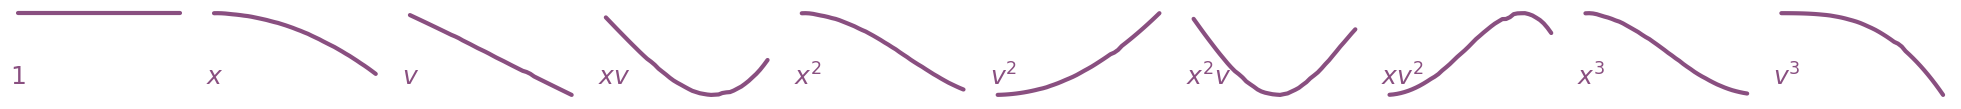

In [12]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, light=0.4, dark=0.4, reverse=True)

# Create a row of plots
g = sns.FacetGrid(
    data_graph_df, col="function", hue="function", aspect=1, height=2, palette=pal
)

# Plot the functions themselves
g.map(sns.lineplot, "t", "value", clip_on=False, alpha=1, lw=3)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0,
        0.25,
        f"${label}$",
        fontweight="bold",
        color=color,
        ha="left",
        va="center",
        fontsize=18,
        transform=ax.transAxes,
    )


g.map(label, "value")

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], xticks=[])
g.set(xlabel="")
g.despine(bottom=True, left=True)

# Save results
if save_plots:
    fname = "figures/library"
    plt.savefig(fname + ".pdf", bbox_inches="tight", pad_inches=0)

plt.show()

# Reset defaults so that later plots aren't affected
sns.reset_defaults()


## Figure 6: Coefficient heatmaps

### Collect coefficients when group sparsity is not enforced

In [13]:
kwargs = {
    "thresh": 0.04,
    "diff_method": "centered_difference",
    "smoother": smoother,
    "window_length": window_length,
    "remove_const": False,
    "drag_coeff": None,
    "library_type": "polynomial",
}

vanilla_dfs = []
for drop in [1, 2]:
    df = pd.DataFrame(index=library.keys())
    for ball in ball_list:
        ball_df = bd_data[ball].loc[bd_data[ball]["Drop #"] == drop]

        h = ball_df["Height (m)"].values
        t = ball_df["Time (s)"].values

        ntc = helpers.need_to_clip(t)
        if ntc:
            h = h[:ntc]
            t = t[:ntc]

        sb = helpers.SINDyBall(**kwargs)
        sb.fit(h, t)

        coeffs = sb.get_xi()
        labels = sb.get_labels()
        coeff_series = pd.Series(coeffs, index=labels, name=ball)
        df[ball] = coeff_series

    vanilla_dfs.append(df)

### Collect coefficients when group sparsity is enforced

In [14]:
# Parameters to use
kwargs = {
    "thresh": 1.5,
    "group_sparse_method": "1-norm",
    "normalize": False,
    "plot_error": False,
    "library_type": "polynomial",
    "model_to_subtract": None,
}

all_coefficient_dict1 = {ball: {"1": []} for ball in bd_data.keys()}
all_coefficient_dict2 = {ball: {"1": []} for ball in bd_data.keys()}

with warnings.catch_warnings():  # Suppres ODEintWarning
    warnings.filterwarnings("ignore")

    gs_error12 = helpers.test_group_sparsity(
        bd_data,
        drops=[1],
        plot_drop=2,
        all_coefficient_dict=all_coefficient_dict1,
        **kwargs
    )

    gs_error21 = helpers.test_group_sparsity(
        bd_data,
        drops=[2],
        plot_drop=1,
        all_coefficient_dict=all_coefficient_dict2,
        **kwargs
    )

gs_df1 = (
    pd.DataFrame.from_dict(all_coefficient_dict1, orient="index")
    .applymap(lambda l: l[0])
    .transpose()
)
gs_df2 = (
    pd.DataFrame.from_dict(all_coefficient_dict2, orient="index")
    .applymap(lambda l: l[0])
    .transpose()
)

Average equation: 
v'  =  (-8.349103*1) + (-0.150070*v) 

Average equation: 
v'  =  (-8.654535*1) + (-0.193314*v) 



### Generate coefficient heatmaps

In [15]:
# Get rid of ticks
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Reorder columns
gs_df1 = gs_df1[drop_viz_list]
gs_df2 = gs_df2[drop_viz_list]
vanilla_dfs = [df[drop_viz_list] for df in vanilla_dfs]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


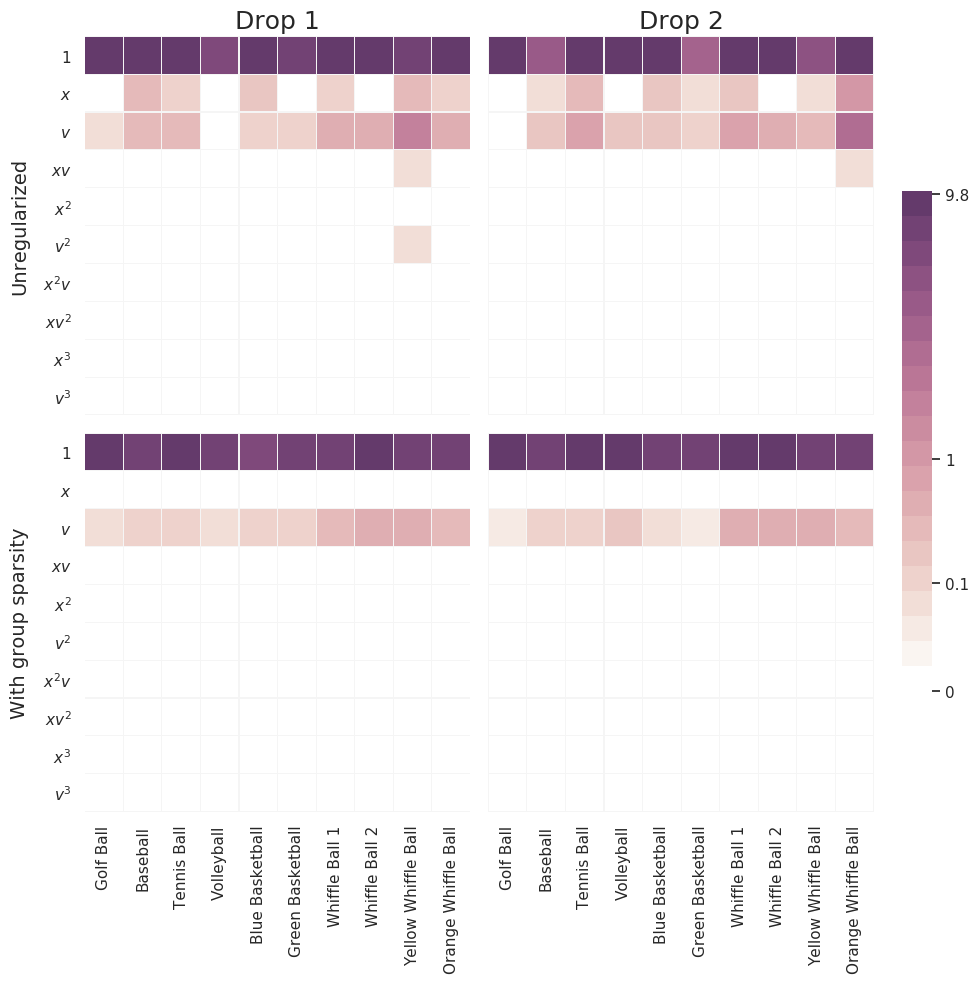

In [16]:
# Generate the heatmaps and put in one figure
title_fontsize = 18
axes_fontsize = 14

cbar_tick_labels = [0, 0.1, 1, 9.8]
cbar_ticks = [np.cbrt(l) for l in cbar_tick_labels]
cbar_tick_labels = list(map(str, cbar_tick_labels))

tex_labels = np.array(["$" + s + "$" for s in gs_df1.index])
heatmap_args = {
    "yticklabels": tex_labels,
    "vmin": 0,
    "vmax": np.cbrt(10),
    "cmap": sns.cubehelix_palette(20, dark=0.3, light=1),
    "linewidths": 0.1,
    "linecolor": "whitesmoke",
}


fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.5])

# This heatmap's entries define the colorbar
sns.heatmap(
    np.cbrt(np.abs(vanilla_dfs[0])),
    ax=axs[0, 0],
    cbar_ax=cbar_ax,
    cbar_kws={"ticks": cbar_ticks},
    **heatmap_args
)
sns.heatmap(np.cbrt(np.abs(vanilla_dfs[1])), ax=axs[0, 1], cbar=False, **heatmap_args)

sns.heatmap(np.cbrt(np.abs(gs_df1)), ax=axs[1, 0], cbar=False, **heatmap_args)
sns.heatmap(np.cbrt(np.abs(gs_df2)), ax=axs[1, 1], cbar=False, **heatmap_args)

for ax in axs.flatten():
    ax.tick_params(axis="y", rotation=0)


# Annotate
axs[0, 0].set_title("Drop 1", fontsize=title_fontsize)
axs[0, 1].set_title("Drop 2", fontsize=title_fontsize)

axs[0, 0].set_ylabel("Unregularized", fontsize=axes_fontsize, labelpad=10)
axs[1, 0].set_ylabel("With group sparsity", fontsize=axes_fontsize, labelpad=10)

cbar_ax.set_yticklabels(cbar_tick_labels)

fig.tight_layout(rect=[0, 0, 0.9, 1])

if save_plots:
    fname = "figures/heatmaps"
    plt.savefig(fname + ".pdf", bbox_inches="tight", pad_inches=0)

plt.show()


## Figure 7: Synthetic data coefficient heatmaps

### Generate synthetic data set

In [17]:
# Generate representative example balls
accel = -9.8
drags = [-0.1, -0.3, -0.3, -0.5, -0.7]
noise_levels = [0, 0.01, 0.1, 0.5, 1, 2]

seed = 100
np.random.seed(seed=seed)

synthetic_data = OrderedDict()

for k, drag in enumerate(drags):
    ball_string = "Ball " + str(k + 1)
    ball_df = pd.DataFrame(columns=["Time (s)", "Height (m)", "Drop #"])
    for noise in noise_levels:
        h, t = helpers.synthetic_ball_drop(accel, drag, noise=noise)
        temp_df = pd.DataFrame.from_dict({"Time (s)": t, "Height (m)": h})
        temp_df["Drop #"] = noise
        ball_df = ball_df.append(temp_df, ignore_index=True)

    synthetic_data[ball_string] = ball_df

### Collect coefficients when group sparsity is enforced

In [18]:
kwargs = {
    "thresh": 1.5,
    "group_sparse_method": "1-norm",
    "plot_error": False,
    "library_type": "polynomial",
    "window_length": 35,
}

all_coefficient_list = []
for k in range(len(noise_levels)):
    all_coefficient_list.append({ball: {"1": []} for ball in synthetic_data.keys()})

with warnings.catch_warnings():  # Suppres ODEintWarning
    warnings.filterwarnings("ignore")

    for k, noise in enumerate(noise_levels):
        gs_error = helpers.test_group_sparsity(
            synthetic_data,
            drops=[noise_levels[k]],
            plot_drop=noise_levels[k],
            all_coefficient_dict=all_coefficient_list[k],
            **kwargs
        )

gs_dfs = [
    pd.DataFrame.from_dict(cd, orient="index").applymap(lambda l: l[0]).transpose()
    for cd in all_coefficient_list
]


Average equation: 
v'  =  (-9.611605*1) + (-0.366283*v) 

Average equation: 
v'  =  (-9.611840*1) + (-0.366587*v) 

Average equation: 
v'  =  (-9.741560*1) + (-0.378919*v) 

Average equation: 
v'  =  (-9.296190*1) + (-0.326685*v) 

Average equation: 
v'  =  (13.905271*1) + (-0.392446*x) + (0.474940*v) 

Average equation: 
v'  =  (-15.694411*1) + (0.082543*x) + (-0.608288*v) 



### Collect coefficients when group sparsity is not enforced

In [19]:
library = {
    "1": lambda x, v: 1,
    "x": lambda x, v: x,
    "v": lambda x, v: v,
    "xv": lambda x, v: x * v,
    "x^2": lambda x, v: x ** 2,
    "v^2": lambda x, v: v ** 2,
    "x^2v": lambda x, v: (x ** 2) * v,
    "xv^2": lambda x, v: x * (v ** 2),
    "x^3": lambda x, v: x ** 3,
    "v^3": lambda x, v: v ** 3,
}

kwargs = {
    "thresh": 0.05,
    "diff_method": "centered_difference",
    "smoother": smoother,
    "window_length": window_length,
    "remove_const": False,
    "drag_coeff": None,
    "library_type": "polynomial",
}

vanilla_dfs = []
for drop in noise_levels:
    df = pd.DataFrame(index=library.keys())
    for ball in synthetic_data.keys():
        ball_df = synthetic_data[ball].loc[synthetic_data[ball]["Drop #"] == drop]

        h = ball_df["Height (m)"].values
        t = ball_df["Time (s)"].values

        ntc = helpers.need_to_clip(t)
        if ntc:
            h = h[:ntc]
            t = t[:ntc]

        sb = helpers.SINDyBall(**kwargs)
        sb.fit(h, t)

        coeffs = sb.get_xi()
        labels = sb.get_labels()
        coeff_series = pd.Series(coeffs, index=labels, name=ball)
        df[ball] = coeff_series

    vanilla_dfs.append(df)


### Generate coefficient heatmaps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


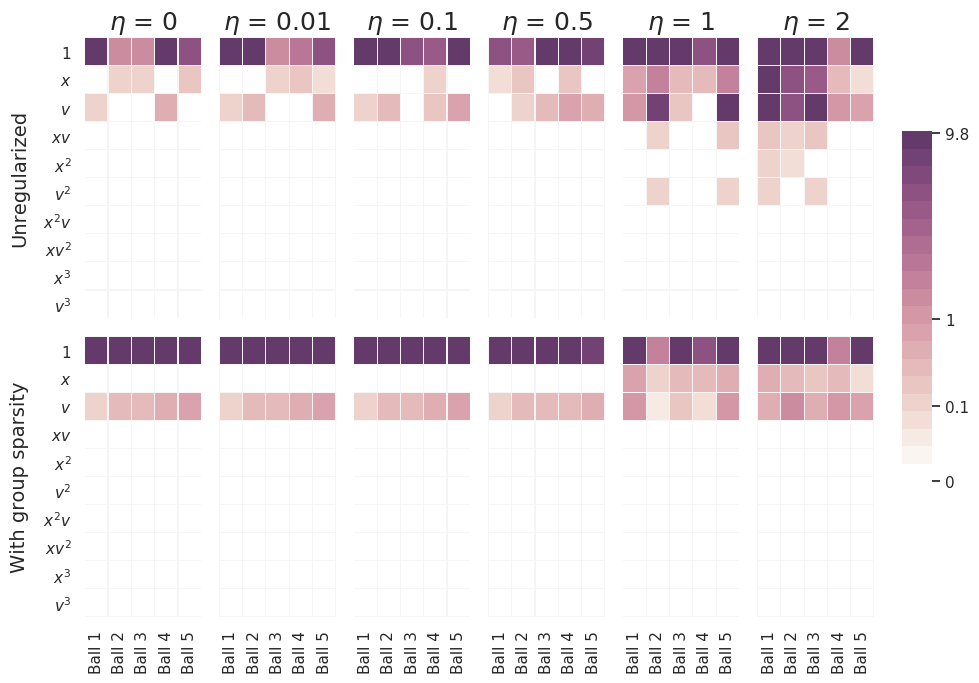

In [20]:
# Generate the heatmaps and put in one figure
n_tests = len(noise_levels)
title_fontsize = 18
axes_fontsize = 14

cbar_tick_labels = [0, 0.1, 1, 9.8]
cbar_ticks = [np.cbrt(l) for l in cbar_tick_labels]
cbar_tick_labels = list(map(str, cbar_tick_labels))

tex_labels = np.array(["$" + s + "$" for s in gs_dfs[0].index])
heatmap_args = {
    "yticklabels": tex_labels,
    "vmin": 0,
    "vmax": np.cbrt(10),
    "cmap": sns.cubehelix_palette(20, dark=0.3, light=1),
    "linewidths": 0.1,
    "linecolor": "whitesmoke",
}


fig, axs = plt.subplots(2, n_tests, figsize=(10, 7), sharey=True, sharex=True)
cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.5])

# This heatmap's entries define the colorbar
sns.heatmap(
    np.cbrt(np.abs(vanilla_dfs[0])),
    ax=axs[0, 0],
    cbar_ax=cbar_ax,
    cbar_kws={"ticks": cbar_ticks},
    **heatmap_args,
)
for k in range(1, n_tests):
    sns.heatmap(
        np.cbrt(np.abs(vanilla_dfs[k])), ax=axs[0, k], cbar=False, **heatmap_args
    )

for k in range(n_tests):
    sns.heatmap(np.cbrt(np.abs(gs_dfs[k])), ax=axs[1, k], cbar=False, **heatmap_args)


for ax in axs.flatten():
    ax.tick_params(axis="y", rotation=0)

# Annotate
for k in range(n_tests):
    axs[0, k].set_title(f"$\eta$ = {noise_levels[k]}", fontsize=title_fontsize)

axs[0, 0].set_ylabel("Unregularized", fontsize=axes_fontsize, labelpad=10)
axs[1, 0].set_ylabel("With group sparsity", fontsize=axes_fontsize, labelpad=10)

cbar_ax.set_yticklabels(cbar_tick_labels)

fig.tight_layout(rect=[0, 0, 0.9, 1])

if save_plots:
    fname = "figures/synthetic_heatmaps_realistic_drag"
    plt.savefig(fname + ".pdf", bbox_inches="tight", pad_inches=0)

plt.show()


## Figure 8: Landing time prediction error

The four models we test are
 1. Constant acceleration: $\ddot x = \alpha$
 2. Constant acceleration with linear drag: $\ddot x = \alpha + \beta v$
 3. Constant acceleration with linear and quadratic drag: $\ddot x = \alpha + \beta v + \gamma v^2$
 4. Overfit model: Set a low sparsity threshold and allow SINDy to fit a more complicated model to the data

### Form the models and compute error

In [21]:
kwargs = {
    "group_sparse_method": "1-norm",
    "normalize": False,
    "plot_error": False,
    "model_to_subtract": None,
    "test_inds": [0, end_time_idx],
}

threshs = [5, 2, 0.05]
library_types = ["polynomial", "polynomial", "polynomial v"]

n_terms = []

global_df = pd.DataFrame(columns=["tailored", "baseline", "Drop", "thresh", "Model"])

for k, thresh in enumerate(threshs):
    kwargs["thresh"] = thresh
    gs_error = []

    with warnings.catch_warnings():  # Suppres ODEintWarning
        warnings.filterwarnings("ignore")

        gs_error.append(
            helpers.test_group_sparsity(
                bd_data,
                drops=[1],
                plot_drop=2,
                library_type=library_types[k],
                n_terms=n_terms,
                **kwargs
            )
        )
        gs_error[0]["Drop"] = 1
        gs_error[0]["thresh"] = thresh
        gs_error[0]["Model"] = k + 1

        global_df = global_df.append(gs_error[0])

        gs_error.append(
            helpers.test_group_sparsity(
                bd_data,
                drops=[2],
                plot_drop=1,
                library_type=library_types[k],
                n_terms=n_terms,
                **kwargs
            )
        )

        gs_error[1]["Drop"] = 2
        gs_error[1]["thresh"] = thresh
        gs_error[1]["Model"] = k + 1

        global_df = global_df.append(gs_error[1])


# We have to do something different for model 4
kwargs = {
    "diff_method": "centered difference",
    "smoother": smoother,
    "window_length": window_length,
    "remove_const": False,
    "drag_coeff": None,
    "library_type": "polynomial",
}

diff_kws = {
    "diff_method": "centered difference",
    "smoother": smoother,
    "window_length": window_length,
}

err_dicts = [{}, {}]
h = []
t = []
v = []
sb = []
h_pred = []

# Learn models using each drop individually
for ball in drop_viz_list:
    for drop in [1, 2]:
        idx = drop - 1
        ball_df = bd_data[ball].loc[bd_data[ball]["Drop #"] == drop]

        h.append(ball_df["Height (m)"].values)
        t.append(ball_df["Time (s)"].values)

        ntc = helpers.need_to_clip(t[idx])
        if ntc:
            h[idx] = h[idx][:ntc]
            t[idx] = t[idx][:ntc]

        sb.append(helpers.SINDyBall(thresh=0.01, **kwargs))
        sb[idx].fit(h[idx], t[idx])

        t[idx] = t[idx][:end_time_idx]
        h[idx] = h[idx][:end_time_idx]
        v.append(helpers.differentiate(h[idx], t[idx], **diff_kws))

    # Use learned models to predict fall time for unseen drop
    h_pred.append(sb[0].predict(y0=[h[1][0], v[1][0]], t=t[1])[:, 0])
    h_pred.append(sb[1].predict(y0=[h[0][0], v[0][0]], t=t[0])[:, 0])

    err_dicts[0][ball] = np.abs(h[1][-1] - h_pred[0][-1])
    err_dicts[1][ball] = np.abs(h[0][-1] - h_pred[1][-1])


for drop in [1, 2]:
    err_df = pd.DataFrame.from_dict(
        err_dicts[drop - 1], orient="index", columns=["tailored"]
    )
    err_df["baseline"] = 0
    err_df["Drop"] = drop
    err_df["thresh"] = 0
    err_df["Model"] = 4
    global_df = global_df.append(err_df)

global_df = np.abs(global_df)
num_cols = ["tailored", "baseline", "Drop", "Model"]
for col in num_cols:
    global_df[col] = pd.to_numeric(global_df[col])
global_df["Ball"] = global_df.index

# Rename a column
global_df = global_df.rename(index=str, columns={"tailored": "Error (m)"})

Average equation: 
v'  =  (-6.976657*1) 

Average equation: 
v'  =  (-6.743516*1) 

Average equation: 
v'  =  (-8.349103*1) + (-0.150070*v) 

Average equation: 
v'  =  (-8.654535*1) + (-0.193314*v) 

Average equation: 
v'  =  (-9.310199*1) + (-0.432132*v) + (-0.014949*v^2) 

Average equation: 
v'  =  (-8.883685*1) + (-0.254482*v) + (-0.002647*v^2) 



### Plot error for each ball

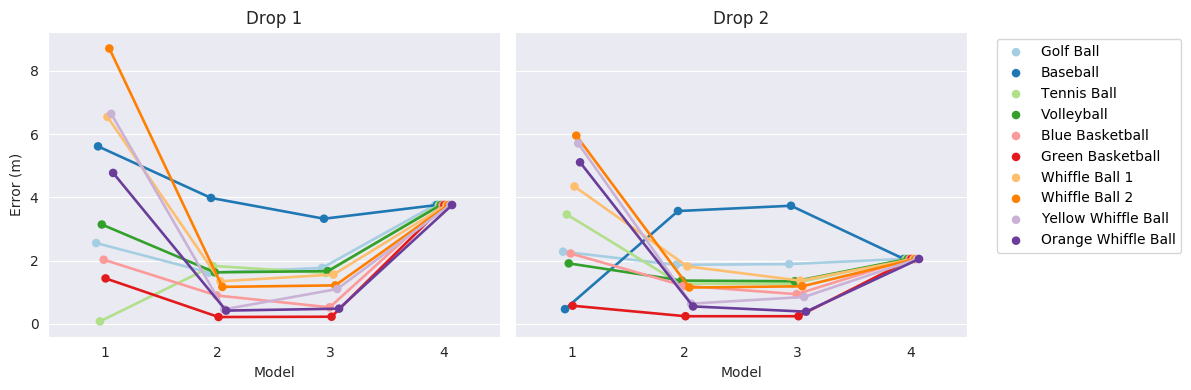

In [22]:
sns.reset_defaults()
pal = sns.color_palette("Paired", n_colors=10)
figsize = (12, 4)

# Plotting options
plot_kws = {
    "x": "Model",
    "y": "Error (m)",
    "hue": "Ball",
    "hue_order": drop_viz_list,
    "palette": pal,
    "scale": 0.7,
    "dodge": 0.15,
}

with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(1, 2, figsize=figsize, sharey=True)

sns.pointplot(data=global_df.loc[global_df["Drop"] == 1], ax=axs[0], **plot_kws)
sns.pointplot(data=global_df.loc[global_df["Drop"] == 2], ax=axs[1], **plot_kws)
axs[0].get_legend().remove()


# Put legend on right of plots
# Solution found here:
# https://stackoverflow.com/questions/30490740/move-legend-outside-figure-in-seaborn-tsplot
l = axs[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

axs[0].set(title="Drop 1")
axs[1].set(title="Drop 2", ylabel=None)

plt.tight_layout()
if save_plots:
    fname = "figures/error_vs_model"
    plt.savefig(fname + ".pdf", bbox_inches="tight", pad_inches=0)

plt.show()

## Figure 9: Predicted trajectories

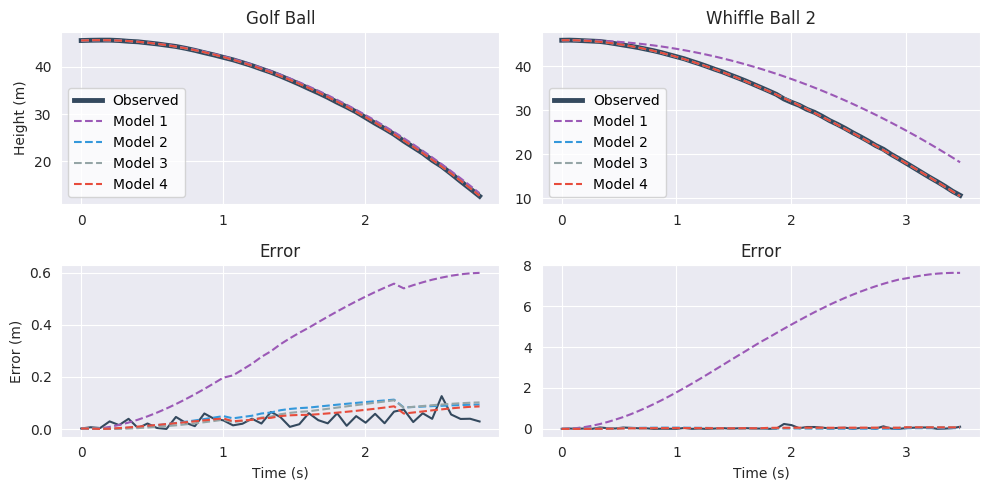

In [23]:
# Set some parameters
color = sns.color_palette(["#34495e", "#9b59b6", "#3498db", "#95a5a6", "#e74c3c"])
matplotlib.rcParams["axes.prop_cycle"] = matplotlib.cycler(color=color)

ex_balls = ["Golf Ball", "Whiffle Ball 2"]
threshs = [2, 0.01, 0.0006, 0.0035]
drop = 2

kwargs = {
    "diff_method": "centered_difference",
    "smoother": smoother,
    "window_length": window_length,
    "remove_const": False,
    "drag_coeff": None,
    "library_type": "polynomial v",
}

models = ["Model 1", "Model 2", "Model 3", "Model 4"]


with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(2, 2, figsize=(10, 5))

# Train the models and plot predictions
for k, ball in enumerate(ex_balls):
    ball_df = bd_data[ball].loc[bd_data[ball]["Drop #"] == drop]

    h = ball_df["Height (m)"].values
    t = ball_df["Time (s)"].values

    ntc = helpers.need_to_clip(t)
    if ntc:
        h = h[:ntc]
        t = t[:ntc]

    predicted_hs = []
    eqns = []

    # Train the four models
    kwargs["library_type"] = "polynomial v"

    # 1 - constant acceleration
    sb = helpers.SINDyBall(thresh=threshs[0], **kwargs)
    sb.fit(h, t)
    eqns.append(sb.get_equation())
    predicted_hs.append(sb.predict(t=t)[:, 0])

    # 2 - acceleration + drag
    sb = helpers.SINDyBall(thresh=threshs[1], **kwargs)
    sb.fit(h, t)
    eqns.append(sb.get_equation())
    predicted_hs.append(sb.predict(t=t)[:, 0])

    # 3 - acceleration + drag + v^2
    sb = helpers.SINDyBall(thresh=threshs[2], **kwargs)
    sb.fit(h, t)
    eqns.append(sb.get_equation())
    predicted_hs.append(sb.predict(t=t)[:, 0])

    # 4 - overfit
    kwargs["library_type"] = "polynomial"
    sb = helpers.SINDyBall(thresh=threshs[3], **kwargs)
    sb.fit(h, t)
    eqns.append(sb.get_equation())
    predicted_hs.append(sb.predict(t=t)[:, 0])

    # Compare the results for the tests
    helpers.plot_prediction(
        h,
        predicted_hs,
        t=t,
        ball=ball,
        eqns=models,
        compare="h smoothed",
        axs=axs[:, k],
        smoother=smoother,
        window_length=window_length,
    )


axs[0, 1].set(ylabel="")
axs[1, 1].set(ylabel="")
plt.tight_layout()

if save_plots:
    fname = "figures/error_vs_time"
    plt.savefig(fname + ".pdf", bbox_inches="tight", pad_inches=0)

plt.show()

## Figure 10: Trajectories for high ball drops

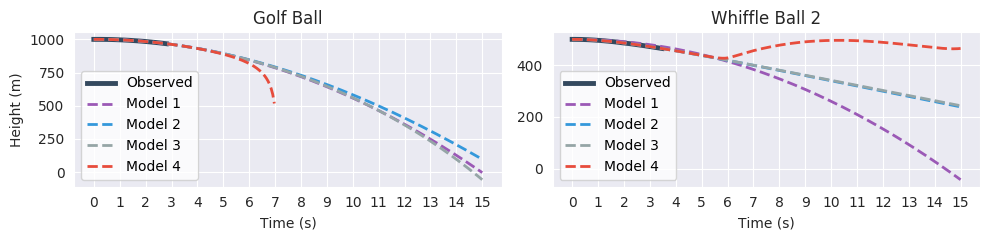

In [24]:
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(1, 2, figsize=(10, 2.5))

with warnings.catch_warnings():  # Suppres ODEintWarning
    warnings.filterwarnings("ignore")
    for k, ball in enumerate(ex_balls):
        ball_df = bd_data[ball].loc[bd_data[ball]["Drop #"] == drop]

        h = ball_df["Height (m)"].values
        t = ball_df["Time (s)"].values

        ntc = helpers.need_to_clip(t)
        if ntc:
            h = h[:ntc]
            t = t[:ntc]

        predicted_hs = []
        eqns = []

        # Train the four models
        kwargs["library_type"] = "polynomial v"

        # Form long time vector
        t_long = np.concatenate((t, np.linspace(t[-1], 15, 200)))

        # Increase height appropriately
        if ball == "Golf Ball":
            h += 1000 - h[0]
        else:
            h += 500 - h[0]

        # 1 - constant acceleration
        sb = helpers.SINDyBall(thresh=threshs[0], **kwargs)
        sb.fit(h, t)
        eqns.append(sb.get_equation())
        predicted_hs.append(sb.predict(t=t_long)[:, 0])

        # 2 - acceleration + drag
        sb = helpers.SINDyBall(thresh=threshs[1], **kwargs)
        sb.fit(h, t)
        eqns.append(sb.get_equation())
        predicted_hs.append(sb.predict(t=t_long)[:, 0])

        # 3 - acceleration + drag + v^2
        sb = helpers.SINDyBall(thresh=threshs[2], **kwargs)
        sb.fit(h, t)
        eqns.append(sb.get_equation())
        predicted_hs.append(sb.predict(t=t_long)[:, 0])

        # 4 - overfit
        kwargs["library_type"] = "polynomial"
        sb = helpers.SINDyBall(thresh=threshs[3], **kwargs)
        sb.fit(h, t)
        eqns.append(sb.get_equation())
        predicted_hs.append(sb.predict(t=t_long)[:, 0])

        # Golf ball model 3 explodes so we pass in the model
        # number and time of blow up
        if ball == "Golf Ball":
            drop_flag = [3, 7]
        else:
            drop_flag = None

        helpers.plot_prediction(
            h,
            predicted_hs,
            t=t,
            ball=ball,
            eqns=models,
            compare="h smoothed",
            axs=axs[k],
            smoother=smoother,
            window_length=window_length,
            t_long=t_long,
            drop_flag=drop_flag,
        )


axs[1].set(ylabel="")
plt.tight_layout()

if save_plots:
    fname = "figures/long_time_predictions"
    plt.savefig(fname + ".pdf", bbox_inches="tight", pad_inches=0)

plt.show()